In [ ]:
# install.packages('rgdal')

In [1]:
library(geojsonR)
library(jsonlite)
library(dplyr)
library(leaflet)
library(sf)
library(geojsonio)
library(maptools)
library(rgdal)
library(XML)
library(xml2)

Warning message:
"package 'geojsonR' was built under R version 3.6.3"Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'sf' was built under R version 3.6.3"Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1
Warning message:
"package 'geojsonio' was built under R version 3.6.3"Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson

Attaching package: 'geojsonio'

The following object is masked from 'package:jsonlite':

    validate

The following object is masked from 'package:base':

    pretty

Warning message:
"package 'maptools' was built under R version 3.6.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.6.3"Checking rgeos avail

### Using getKMLcoordinates (failed)


In [ ]:
tkml <- getKMLcoordinates(kmlfile="C:/Users/admin/Desktop/Untitled Project.kml", ignoreAltitude=T)
#make polygon
p1 = Polygon(tkml)
#make Polygon class
p2 = Polygons(list(p1), ID = "VNM.25_1")
#make spatial polygons class
# p3= SpatialPolygons(list(p2),proj4string=CRS("+init=epsg:4326"))
p2

In [ ]:
spa <- getKMLcoordinates('C:/Users/admin/Desktop/Untitled Project.kml', ignoreAltitude=TRUE)
spa

### Using st_read (successed)

In [2]:
f00 <- st_read("C:/Users/admin/Desktop/Untitled Project.kml")
# head(f00, 3)
# bbox_list <- lapply(st_geometry(f00), st_bbox)
# bbox_list

Reading layer `gadm40_VNM_1' from data source `C:\Users\admin\Desktop\Untitled Project.kml' using driver `KML'
Simple feature collection with 63 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XYZ
Bounding box:  xmin: 102.1446 ymin: 8.381355 xmax: 109.4692 ymax: 23.39269
z_range:       zmin: 0 zmax: 0
Geodetic CRS:  WGS 84


In [ ]:
f00[3][[1]][[29]][1]

In [ ]:
# locations <- st_read('C:/Users/admin/Desktop/Untitled Project.kml', stringsAsFactors = FALSE)

# locations %>%
#   rename(id = Name) %>%
#   mutate(latitude = st_coordinates(geometry)[,1],
#          longitiude = st_coordinates(geometry)[,2],
#          name = sapply(Description, function(x) getHtmlTableCells(x)[1])) %>%
#   st_drop_geometry()


In [3]:
#Get names, id and extended data in KML files.

readKML <- function(file,keep_name_description=TRUE,layer,...) {
  # Set keep_name_description = TRUE to keep "Name" and "Description" columns
  #   in the resulting SpatialPolygonsDataFrame. Only works when there is
  #   ExtendedData in the kml file.

  sp_obj<-readOGR(file,layer,...)
  xml1<-read_xml(file)
  if (!missing(layer)) {
    different_layers <- xml_find_all(xml1, ".//d1:Folder") 
    layer_names <- different_layers %>% 
      xml_find_first(".//d1:name") %>% 
      xml_contents() %>% 
      xml_text()

    selected_layer <- layer_names==layer
    if (!any(selected_layer)) stop("Layer does not exist.")
    xml2 <- different_layers[selected_layer]
  } else {
    xml2 <- xml1
  }

  # extract name and type of variables

  variable_names1 <- 
    xml_find_first(xml2, ".//d1:ExtendedData") %>% 
    xml_children() 

  while(variable_names1 %>% 
        xml_attr("name") %>% 
        is.na() %>% 
        any()&variable_names1 %>%
        xml_children() %>% 
        length>0) variable_names1 <- variable_names1 %>%
    xml_children()

  variable_names <- variable_names1 %>%
    xml_attr("name") %>% 
    unique()

  # return sp_obj if no ExtendedData is present
  if (is.null(variable_names)) return(sp_obj)

  data1 <- xml_find_all(xml2, ".//d1:ExtendedData") %>% 
    xml_children()

  while(data1 %>%
        xml_children() %>% 
        length>0) data1 <- data1 %>%
    xml_children()

  data <- data1 %>% 
    xml_text() %>% 
    matrix(.,ncol=length(variable_names),byrow = TRUE) %>% 
    as.data.frame()

  colnames(data) <- variable_names

  if (keep_name_description) {
    sp_obj@data <- data
  } else {
    try(sp_obj@data <- cbind(sp_obj@data,data),silent=TRUE)
  }
  sp_obj
}


In [4]:
f <- readKML('C:/Users/admin/Desktop/Untitled Project.kml')

OGR data source with driver: KML 
Source: "C:\Users\admin\Desktop\Untitled Project.kml", layer: "gadm40_VNM_1"
with 63 features
It has 2 fields


Warning message in readOGR(file, layer, ...):
"Z-dimension discarded"

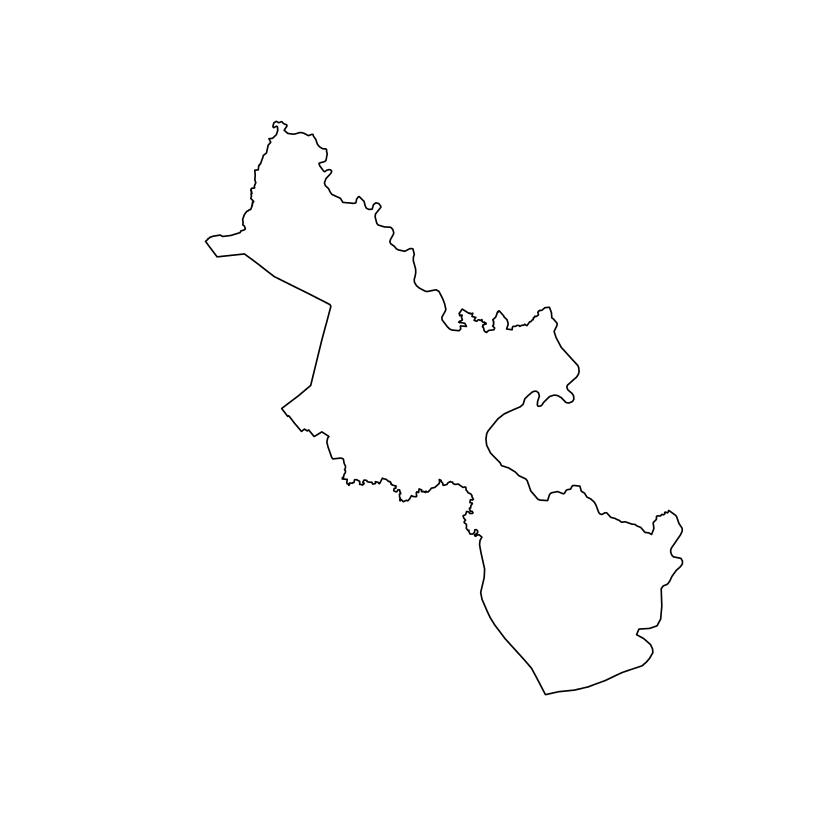

In [6]:
#Get index of Ho Chi Minh (city)

index <- 0
for (i in 1:length(f[3][[1]])) {
    if (f[3][[1]][[i]] == 'Ho Chi Minh')
        index <- i
}
# lst <- (f00[3][[1]][[index]][1])
# capture.output(summary(lst), file = "My New File.txt")
# list <- split(lst, rep(1:ncol(lst), each = nrow(lst)))
# f00[3][[1]][[index]]
plot(f00[3][[1]][[index]])

In [ ]:
mat <- f00[3][[1]][[29]][[1]]
write.table(mat,file="test.csv")

In [ ]:
mat_csv <- read.csv(file='test.csv', sep='')
# mat_csv
names <- c('X', 'Y', 'Z')
colnames(mat_csv) <- names
mat_csv
# write.csv(mat_csv,"tphcm.csv", row.names = FALSE)

In [ ]:
keeps <- c('X', 'Y')
mat_csv_withoutZ <- mat_csv[keeps]
write.csv(mat_csv_withoutZ, 'tphcmXY.csv', row.names=FALSE)

In [ ]:
tphcmXY <- read.csv('tphcmXY.csv', sep=',')
plot(tphcmXY$X, tphcmXY$Y, type='l',
    main='Ho Chi Minh City Polygon',
    xlab=expression(bold('Longitude')), ylab=expression(bold('Latitude')), col='brown') 

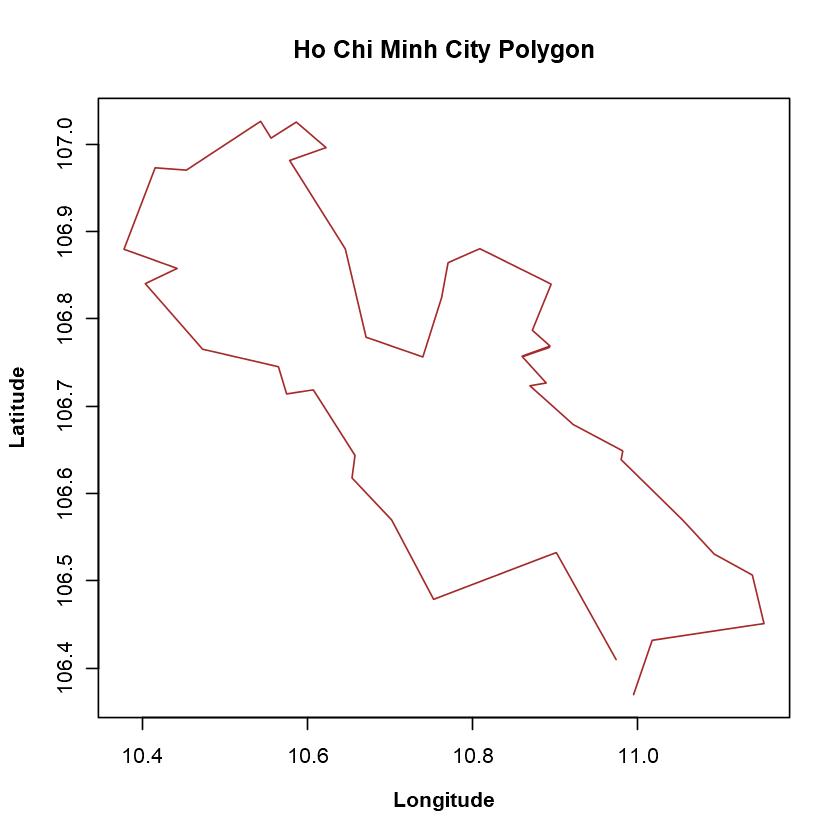

In [8]:
pct <- read.csv('phanchauthang_20520929.csv', sep=',')
plot(pct, type='l',
    main='Ho Chi Minh City Polygon',
    xlab=expression(bold('Longitude')), ylab=expression(bold('Latitude')), col='brown') 